In [93]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import calendar
import random 
import seaborn as sn
import itertools
from dateutil.parser import parse

from sklearn.model_selection import train_test_split

!chcp 65001
!sqlcmd -f 65001 -S tsc-backend-eastus.database.windows.net -U tscadmin -P FI])U6EiM5QMrmG -d shallowcopy-sdh -s"|" -k1 -W -Q "SELECT o.AccountId, o.OpportunityId , o.CreatedDate, o.ActualCloseDate, o.EstimatedCloseDate, HasCustomerAgreedToBuy, o.CreatedById, o.EstimatedValue, o.ActualValue, a.CreatedDate as AccountCreatedDate, a.City as AccountCity, a.EndCustomerSegmentSeqNo, a.EndCustomerSubsegmentSeqNo, a.IndustrySeqNo, a.IndustryVerticalSeqNo, a.VerticalCategorySeqNo, p.PfamSkid, p.PoolSeqNo, p.ProdSkid, p.ProductNumber, p.ProductStructureSeqNo, p.ProductTypeSeqNo FROM [dbo].[Hub_vw_Opportunity] o (nolock) JOIN [dbo].[Hub_vw_OpportunityProduct] op (nolock) on op.OpportunityId = o.OpportunityId JOIN [dbo].[Hub_vw_Product] p (nolock) on op.ProductId = p.ProductId JOIN [dbo].[Hub_vw_Account] a (nolock) on o.AccountId = a.AccountId WHERE a.Country = 'United States' and a.CurrencyId = 'FF2971D7-B412-E411-8D49-6C3BE5A82B68' " >oppty_join.csv


In [261]:
   
#opt = pd.read_csv("d:/repos/forecast/data/oppty_join.csv", sep="|", skiprows=[1], error_bad_lines=True, encoding='iso-8859-1')
date_columns = ['CreatedDate', 'EstimatedCloseDate','ActualCloseDate', 'AccountCreatedDate']

opt = pd.read_csv("d:/repos/forecast/data/oppty_join.csv", sep="|", skiprows=[1], parse_dates=date_columns)#, , date_parser = xplow_memory=False)
#opt.dropna(inplace=True)
opt["EstimatedCloseDate"] = pd.to_datetime(opt['EstimatedCloseDate'], errors="coerce")

opt["actual_days_to_close"] = (opt['ActualCloseDate'] - opt['CreatedDate']).astype('timedelta64[D]')
opt["est_days_to_close"] = (opt['EstimatedCloseDate'] - opt['CreatedDate']).astype('timedelta64[D]')

l = len(opt)
opt.drop( opt[(opt['actual_days_to_close'] > 365*5)].index, inplace=True)
opt.drop( opt[(opt['actual_days_to_close'] < 0)].index, inplace=True)
print('dropped: ', l-len(opt))
l = len(opt)
opt.drop( opt[(opt['est_days_to_close'] > 365*5)].index, inplace=True)
opt.drop( opt[(opt['est_days_to_close'] < 0)].index, inplace=True)
print('dropped: ', l-len(opt))

opt["AccountCreatedYear"] = opt["AccountCreatedDate"].apply(lambda x: x.year)
opt["CreatedMonth"] = opt["CreatedDate"].apply(lambda x: x.month)
opt[opt["PoolSeqNo"].isna()] = 0


D:\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


dropped:  61046
dropped:  49488


In [262]:
def bucket_days(x):
    if (x < 60): return 1
    if (x < 120): return 2
    if (x < 240): return 3
    if (x < 365): return 4
    return 5

opt['days_to_close_bucket'] = opt['actual_days_to_close'].apply(lambda x: bucket_days(x))

opt.describe()

,HasCustomerAgreedToBuy,EstimatedValue,ActualValue,EndCustomerSegmentSeqNo,EndCustomerSubsegmentSeqNo,IndustrySeqNo,IndustryVerticalSeqNo,VerticalCategorySeqNo,PoolSeqNo,ProductStructureSeqNo,ProductTypeSeqNo,actual_days_to_close,est_days_to_close,AccountCreatedYear,CreatedMonth,days_to_close_bucket
count,2.734050e+06,3.534009e+06,2.936287e+06,3.534088e+06,3.534088e+06,3.487547e+06,3.487549e+06,3.487560e+06,2.373186e+06,3.534088e+06,3.533018e+06,3.174888e+06,3.529326e+06,3.534088e+06,3.534088e+06,3.534089e+06
mean,1.875240e-03,4.137015e+05,3.759894e+05,5.081786e+03,5.161225e+03,3.579190e+03,5.425944e+02,2.086428e+02,5.618932e+02,3.084001e+03,3.614786e+02,2.426028e+02,2.503597e+02,2.004131e+03,5.573482e+00,3.451086e+00
std,4.326343e-02,7.237852e+06,2.705066e+06,1.515604e+00,2.425011e+02,2.495790e+03,1.238287e+03,8.006255e+02,6.487602e-01,3.604339e-02,3.171765e+02,1.753376e+02,1.664316e+02,5.447112e+00,2.931267e+00,1.328255e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,5.080000e+03,5.087000e+03,2.570000e+02,1.970000e+02,1.100000e+01,5.610000e+02,3.084000e+03,3.030000e+02,0.000000e+00,0.000000e+00,1.998000e+03,1.000000e+00,1.000000e+00
25%,0.000000e+00,9.263450e+03,0.000000e+00,5.080000e+03,5.090000e+03,2.610000e+02,2.120000e+02,3.800000e+01,5.620000e+02,3.084000e+03,3.340000e+02,1.170000e+02,1.280000e+02,1.999000e+03,3.000000e+00,3.000000e+00
50%,0.000000e+00,5.000000e+04,3.419700e+04,5.082000e+03,5.097000e+03,5.340000e+03,2.260000e+02,8.100000e+01,5.620000e+02,3.084000e+03,3.340000e+02,2.220000e+02,2.330000e+02,2.002000e+03,5.000000e+00,4.000000e+00
75%,0.000000e+00,1.812496e+05,1.573870e+05,5.082000e+03,5.099000e+03,5.346000e+03,2.440000e+02,1.210000e+02,5.620000e+02,3.084000e+03,3.340000e+02,3.380000e+02,3.380000e+02,2.008000e+03,8.000000e+00,5.000000e+00
max,1.000000e+00,9.900000e+09,1.125000e+09,5.086000e+03,6.057000e+03,6.056000e+03,6.106000e+03,5.410000e+03,5.640000e+02,3.086000e+03,5.750000e+03,1.825000e+03,1.825000e+03,2.018000e+03,1.200000e+01,5.000000e+00


array([4, 1, 3, 2, 5], dtype=int64)

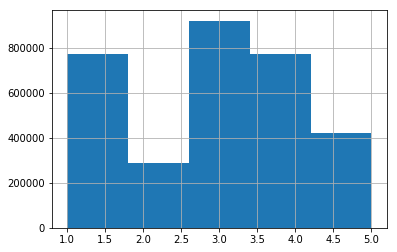

In [298]:
def bucket_value(x):
    if (x == np.nan): return 1
    if (x <=0): return 1
    if (x < 1E4): return 2
    if (x < 1E5): return 3
    if (x < 1E6): return 4
    if (x < 1E7): return 5
    return 5

opt['ActualValue_bucket'] = opt['ActualValue'].apply(lambda x: bucket_value(x))


opt['ActualValue_bucket'].hist(bins=len(opt['ActualValue_bucket'].unique()))
opt['ActualValue_bucket'].unique()

In [264]:
opt.columns

Index(['AccountId', 'OpportunityId', 'CreatedDate', 'ActualCloseDate',
       'EstimatedCloseDate', 'HasCustomerAgreedToBuy', 'CreatedById',
       'EstimatedValue', 'ActualValue', 'AccountCreatedDate', 'AccountCity',
       'EndCustomerSegmentSeqNo', 'EndCustomerSubsegmentSeqNo',
       'IndustrySeqNo', 'IndustryVerticalSeqNo', 'VerticalCategorySeqNo',
       'PfamSkid', 'PoolSeqNo', 'ProdSkid', 'ProductNumber',
       'ProductStructureSeqNo', 'ProductTypeSeqNo', 'actual_days_to_close',
       'est_days_to_close', 'AccountCreatedYear', 'CreatedMonth',
       'days_to_close_bucket', 'ActualValue_bucket'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C9B7D77DA0>,
      dtype=object)

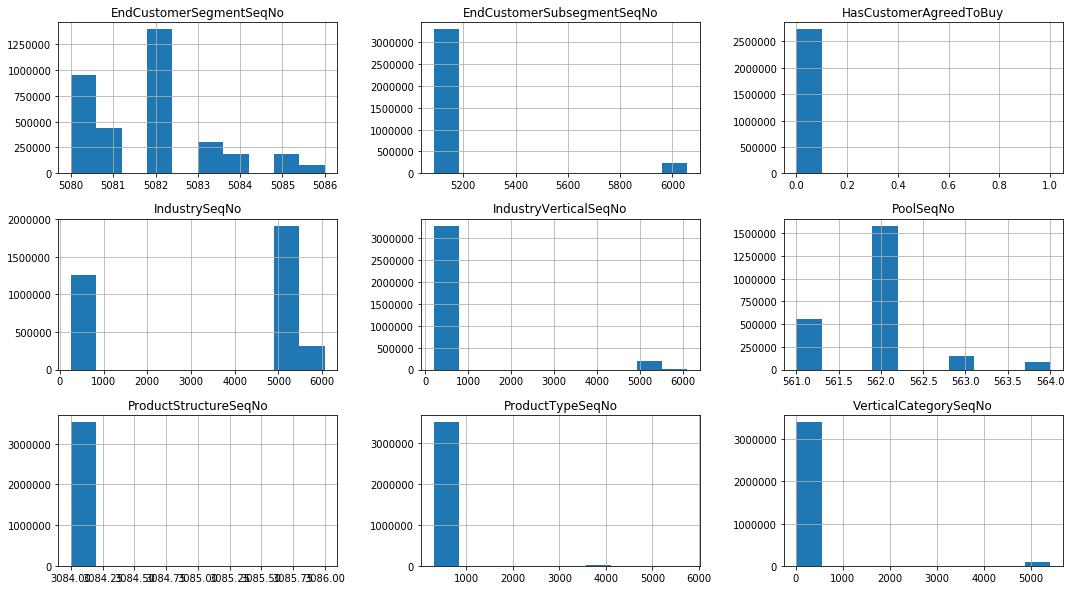

In [97]:
categorical_columns = ['HasCustomerAgreedToBuy', 'AccountCity',
       'EndCustomerSegmentSeqNo', 'EndCustomerSubsegmentSeqNo',
       'IndustrySeqNo', 'IndustryVerticalSeqNo', 'VerticalCategorySeqNo',
       'PfamSkid', 'PoolSeqNo', 'ProdSkid', 'ProductNumber',
       'ProductStructureSeqNo', 'ProductTypeSeqNo']

opt[categorical_columns].hist(figsize=(18,10))

In [316]:
opt["PoolSeqNo"].value_counts()

562.0    1452043
0.0      1003377
561.0     510370
563.0     140026
564.0      69072
Name: PoolSeqNo, dtype: int64

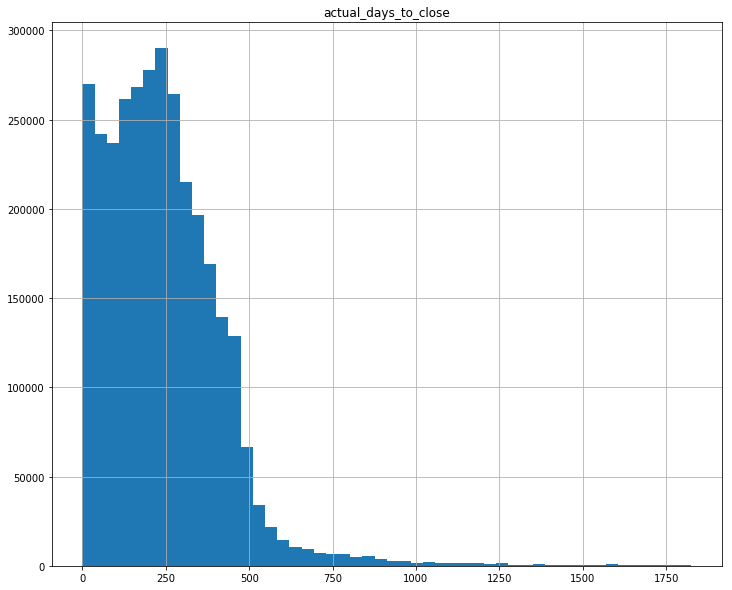

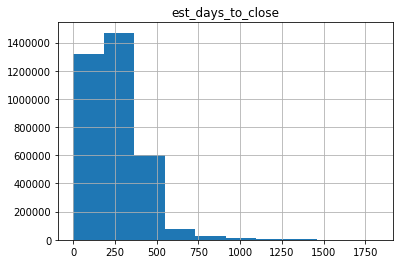

In [98]:
#opt[ ['est_days_to_close', 'actual_days_to_close']]

plt.figure(figsize=(12,10))
plt.title("actual_days_to_close")
opt['actual_days_to_close'].hist(label='x', bins=50)
plt.figure()
plt.title("est_days_to_close")
opt['est_days_to_close'].hist()

In [265]:
categorical_columns = ['HasCustomerAgreedToBuy', 'AccountCity',
       'EndCustomerSegmentSeqNo', 'EndCustomerSubsegmentSeqNo',
       'IndustrySeqNo', 'IndustryVerticalSeqNo', 'VerticalCategorySeqNo',
       'PfamSkid', 'PoolSeqNo', 'ProdSkid', 'ProductNumber',
       'ProductStructureSeqNo', 'ProductTypeSeqNo']

def featurize(opt, cat_features):
    for f in cat_features:
        opt[f] = opt[f].astype('category')

    opt[cat_features] = opt[cat_features].apply(lambda x: x.cat.codes)

    opt = opt.drop( opt[opt["actual_days_to_close"].isna()].index )

    return opt

opt = featurize(opt, cat_features)

In [266]:
def train_test(opt, features, label):
    X = opt[features]
    y = opt[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    #print(f"Training Size: {len(X_train):,}")
    #print(f"Testing Size.: {len(X_test):,}")
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = build_train_test(opt, cat_features)
# pd.concat([X_train, y_train], axis=1, sort=False).head()


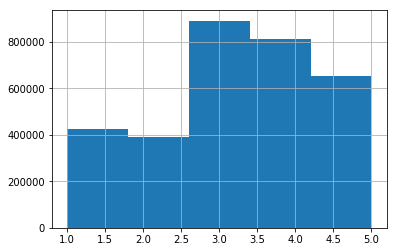

In [278]:
bins = len(opt['days_to_close_bucket'].unique())
opt['days_to_close_bucket'].hist(bins=bins)

In [247]:
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold

In [317]:
# evaluate single features
def train_single_feature(df, feature_name, label):
   
    df = df[[feature_name, label]].copy()
    
        
    X_train, X_test, y_train, y_test = train_test(df, [feature_name], label)
    
    model = tree.DecisionTreeClassifier(max_depth=5)
    try:
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        # print("Accuracy: {:.4f}".format(acc))
    except Exception as ex:
        print(feature_name, ex)
        acc = 0
        
    return acc
    
def evaluate_features(df, features, label):
    
    scores = [(f, train_single_feature(df, f, label)) for f in features]
    scores = [(f,s) for f,s in scores if s > 0]
    scores.sort(reverse=True, key = lambda x: x[1])
    return (scores)
    
columns_to_evaluate = opt.columns

label = ""
scores = evaluate_features(opt, columns_to_evaluate, label="days_to_close_bucket")

print("\n", scores)


AccountId could not convert string to float: '853823F0-92E1-47EB-A075-7C8CDA1AA60D'
OpportunityId could not convert string to float: '55FB462F-11ED-E411-80EC-C4346BAD3644'
CreatedDate float() argument must be a string or a number, not 'Timestamp'
ActualCloseDate float() argument must be a string or a number, not 'Timestamp'
EstimatedCloseDate float() argument must be a string or a number, not 'Timestamp'
HasCustomerAgreedToBuy Input contains NaN, infinity or a value too large for dtype('float32').
EstimatedValue Input contains NaN, infinity or a value too large for dtype('float32').
ActualValue Input contains NaN, infinity or a value too large for dtype('float32').
AccountCreatedDate float() argument must be a string or a number, not 'Timestamp'
IndustryVerticalSeqNo Input contains NaN, infinity or a value too large for dtype('float32').
VerticalCategorySeqNo Input contains NaN, infinity or a value too large for dtype('float32').
ProdSkid could not convert string to float: '3PJ'
Produc

In [318]:
# baseline 
#cat_features = ["AccountCity", 'ProductNumber', "IndustrySeqNo", "CreatedById", "EndCustomerSubsegmentSeqNo", 'ProductStructureSeqNo']
cat_features = ["AccountCity",  "AccountCreatedYear", "IndustrySeqNo", "CreatedById", 
                "EndCustomerSubsegmentSeqNo", "ActualValue_bucket", "CreatedMonth", "PoolSeqNo"]
features = cat_features
label = "days_to_close_bucket"

X_train, X_test, y_train, y_test = train_test(opt, features, label)

print("Features", X_train.columns)
print("X_train {:,}".format(len(X_train)))

params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
#model = ensemble.GradientBoostingClassifier(**params)
model = tree.DecisionTreeClassifier() #max_depth=2)


model.fit(X_train, y_train)

acc = model.score(X_test, y_test)

print("Accuracy: {:.4f} ***".format(acc))

y_pred = model.predict(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=model.predict(X_test))
print(sk_report)

print(confusion_matrix(y_test, y_pred))

print(dict(zip(X_train.columns, model.feature_importances_)))


Features Index(['AccountCity', 'AccountCreatedYear', 'IndustrySeqNo', 'CreatedById',
       'EndCustomerSubsegmentSeqNo', 'ActualValue_bucket', 'CreatedMonth',
       'PoolSeqNo'],
      dtype='object')
X_train 2,222,421
Accuracy: 0.9195 ***
             precision    recall  f1-score   support

          0   1.000000  1.000000  1.000000    301041
          1   0.823498  0.825223  0.824359     79713
          2   0.815709  0.813228  0.814467     72345
          3   0.897000  0.894016  0.895506    184264
          4   0.907292  0.907561  0.907427    175100
          5   0.899671  0.903617  0.901640    140004

avg / total   0.919513  0.919522  0.919516    952467

[[301041      0      0      0      0      0]
 [     0  65781   5225   4126   2277   2304]
 [     0   5428  58833   4197   2050   1837]
 [     0   4197   4251 164735   6547   4534]
 [     0   2192   2069   6492 158914   5433]
 [     0   2282   1747   4101   5364 126510]]
{'AccountCity': 0.24404471896850197, 'AccountCreatedYear': 0

In [319]:
# baseline 
#cat_features = ["AccountCity", 'ProductNumber', "IndustrySeqNo", "CreatedById", "EndCustomerSubsegmentSeqNo", 'ProductStructureSeqNo']

cat_features = ["AccountCity",  "AccountCreatedYear", "IndustrySeqNo", "CreatedById", 
                "EndCustomerSubsegmentSeqNo", "ActualValue_bucket", "CreatedMonth"]

features = cat_features
label = "days_to_close_bucket"

X_train, X_test, y_train, y_test = train_test(opt, features, label) # .sample(n=1500000)

print("Features", X_train.columns)
print("X_train {:,}".format(len(X_train)))

model = ensemble.RandomForestClassifier(n_estimators=30, n_jobs=-1)

model.fit(X_train, y_train)

acc = model.score(X_test, y_test)

print("Accuracy: {:.4f} ***".format(acc))

y_pred = model.predict(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=model.predict(X_test))
print(sk_report)

print(confusion_matrix(y_test, y_pred))

print(dict(zip(X_train.columns, model.feature_importances_)))


Features Index(['AccountCity', 'AccountCreatedYear', 'IndustrySeqNo', 'CreatedById',
       'EndCustomerSubsegmentSeqNo', 'ActualValue_bucket', 'CreatedMonth'],
      dtype='object')
X_train 2,222,421
Accuracy: 0.9267 ***
             precision    recall  f1-score   support

          0   1.000000  1.000000  1.000000    301041
          1   0.829726  0.853073  0.841237     79713
          2   0.851840  0.817458  0.834295     72345
          3   0.899593  0.905310  0.902442    184264
          4   0.918540  0.913923  0.916226    175100
          5   0.908890  0.911395  0.910141    140004

avg / total   0.926703  0.926671  0.926644    952467

[[301041      0      0      0      0      0]
 [     0  68001   4080   3975   1754   1903]
 [     0   5591  59139   4256   1796   1563]
 [     0   4164   3255 166816   5911   4118]
 [     0   2037   1641   6187 160028   5207]
 [     0   2163   1310   4201   4731 127599]]
{'AccountCity': 0.2866024941603307, 'AccountCreatedYear': 0.15196614756563, 'Ind

In [81]:
confusion_matrix(y_test, y_pred)

array([[ 76299,  15792,  16522,  10510,   8305],
       [ 18066,  58476,  20564,  12009,   8513],
       [ 19198,  22257, 168267,  36473,  21539],
       [ 12355,  13945,  41738, 146200,  29415],
       [ 10429,   9843,  25736,  34715, 115301]], dtype=int64)

In [232]:
#model.feature_importances_
print(dict(zip(X_train.columns, model.feature_importances_)))

{'AccountCity': 0.6032746490958393, 'IndustrySeqNo': 0.0951403093935618, 'CreatedById': 0.22808020554743322, 'EndCustomerSubsegmentSeqNo': 0.0481908062279615, 'ActualValue_bucket': 0.02531402973520418}
